# Donor Choose

In [138]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


#from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import 
from keras.layers import Input, Embedding, LSTM, Dropout, BatchNormalization, Dense, concatenate, Flatten, Conv1D, MaxPool1D, LeakyReLU, ELU, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras import regularizers
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

In [139]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [140]:
!ls /content/drive/My\ Drive/Colab\ Notebooks

Donors_Choose_1.ipynb		      Model_1.ipynb	     train_data.csv
DonorsChoose_Model_1_13_Aug_19.ipynb  Model_2.ipynb	     Untitled0.ipynb
DonorsChoose_Model_2_13_Aug_19.ipynb  preprocessed_data.csv
glove_vectors			      resources.csv


## 1.1 Reading Data

In [0]:
project_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/train_data.csv")
resource_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/resources.csv')

In [142]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [149]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity   price
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1  149.00
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   14.95

## 1.2 Data Analysis

Number of projects thar are approved for funding  92706 , ( 84.85830404217927 %)
Number of projects thar are not approved for funding  16542 , ( 15.141695957820739 %)


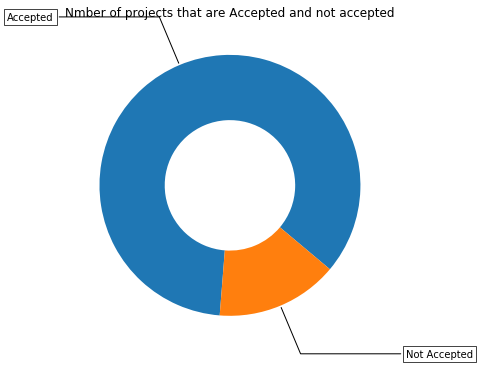

In [150]:
# this code is taken from 
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py


y_value_counts = project_data['project_is_approved'].value_counts()
print("Number of projects thar are approved for funding ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects thar are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Accepted", "Not Accepted"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of projects that are Accepted and not accepted")

plt.show()

### 1.2.1 Univariate Analysis: School State


In [151]:
# Pandas dataframe grouby count, mean: https://stackoverflow.com/a/19385591/4084039

temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
# if you have data which contain only 0 and 1, then the mean = percentage (think about it)
temp.columns = ['state_code', 'num_proposals']

# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = temp['state_code'],
        z = temp['num_proposals'].astype(float),
        locationmode = 'USA-states',
        text = temp['state_code'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
    ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='us-map-heat-map')

In [152]:
# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['num_proposals'], inplace=True)
print("States with lowest % approvals")
print(temp.head(5))
print('='*50)
print("States with highest % approvals")
print(temp.tail(5))

States with lowest % approvals
   state_code  num_proposals
46         VT       0.800000
7          DC       0.802326
43         TX       0.813142
26         MT       0.816327
18         LA       0.831245
States with highest % approvals
   state_code  num_proposals
30         NH       0.873563
35         OH       0.875152
47         WA       0.876178
28         ND       0.888112
8          DE       0.897959


In [0]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('% of projects aproved state wise')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [0]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

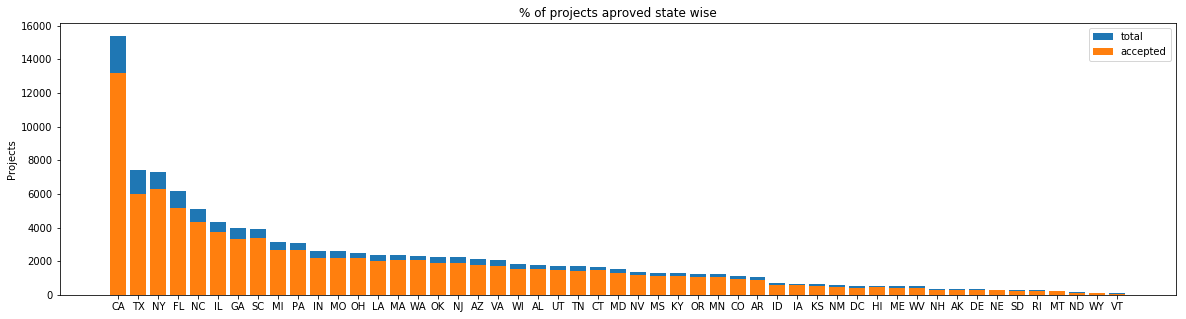

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [155]:
univariate_barplots(project_data, 'school_state', 'project_is_approved', False)

__Every state is having more than 80% success rate in approval__

### 1.2.2 Univariate Analysis: teacher_prefix

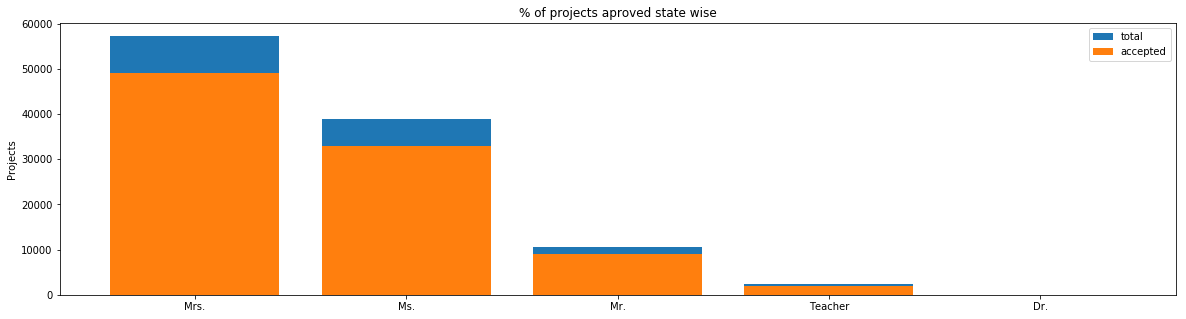

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [156]:
univariate_barplots(project_data, 'teacher_prefix', 'project_is_approved' , top=False)

### 1.2.3 Univariate Analysis: project_grade_category

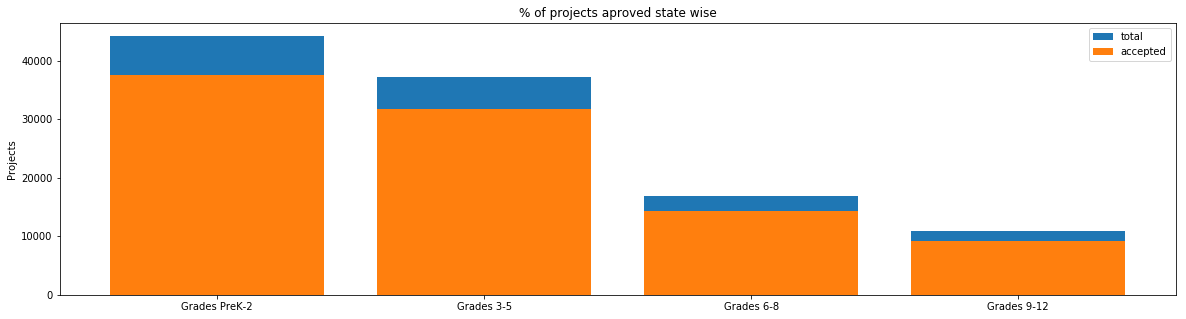

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [157]:
univariate_barplots(project_data, 'project_grade_category', 'project_is_approved', top=False)

### 1.2.4 Univariate Analysis: project_subject_categories

In [0]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [159]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id  ... project_is_approved              clean_categories
0      160221  p253737  ...                   0             Literacy_Language
1      140945  p258326  ...                   1  History_Civics Health_Sports

[2 rows x 17 columns]

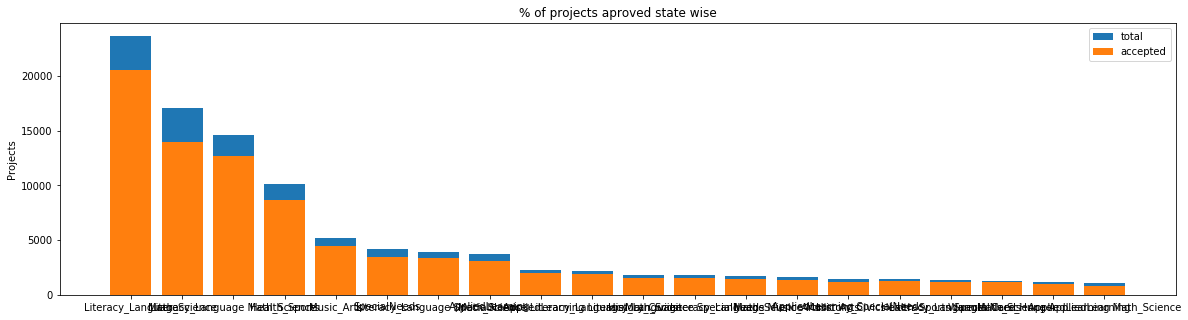

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738


In [160]:
univariate_barplots(project_data, 'clean_categories', 'project_is_approved', top=20)

In [0]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

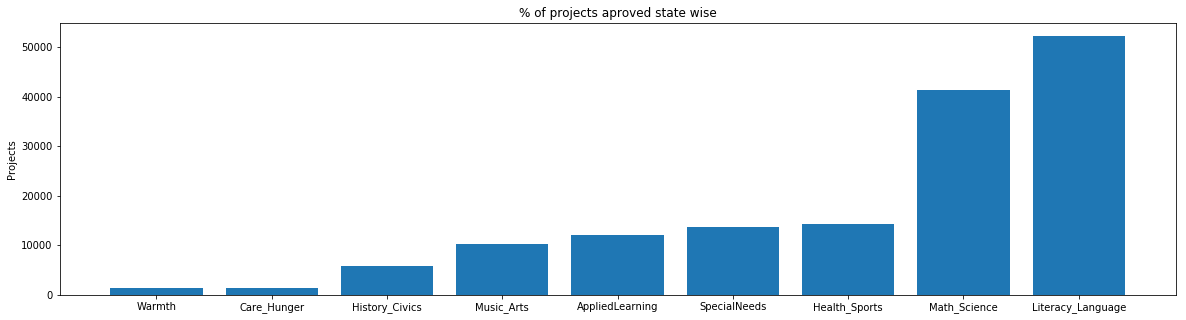

In [162]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [163]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


### 1.2.5 Univariate Analysis: project_subject_subcategories

In [0]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [165]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0  ...           clean_subcategories
0      160221  ...                  ESL Literacy
1      140945  ...  Civics_Government TeamSports

[2 rows x 17 columns]

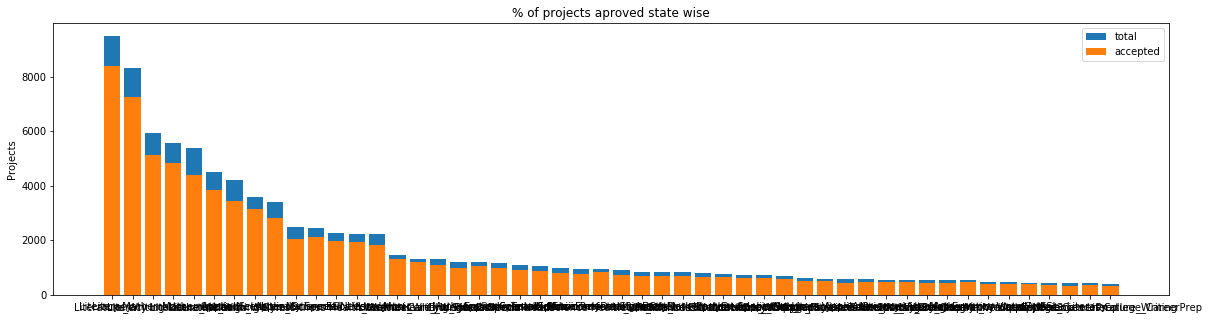

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                    clean_subcategories  project_is_approved  total       Avg
196       EnvironmentalScience Literacy                  389    444  0.876126
127                                 ESL                  349    421  0.828979
79                   College_CareerPrep                  343    421  0.814727
17   AppliedSciences Literature_Writing                  361    420  0.859524
3    AppliedSciences College_CareerPrep                  330    405  0.814815


In [166]:
univariate_barplots(project_data, 'clean_subcategories', 'project_is_approved', top=50)

In [0]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

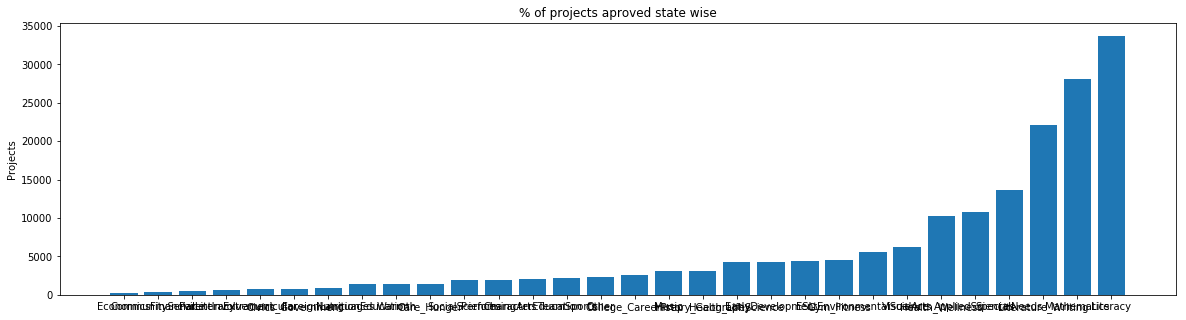

In [168]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()

In [169]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Warmth               :      1388
Care_Hunger          :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700


### 1.2.6 Univariate Analysis: Text features (Title)

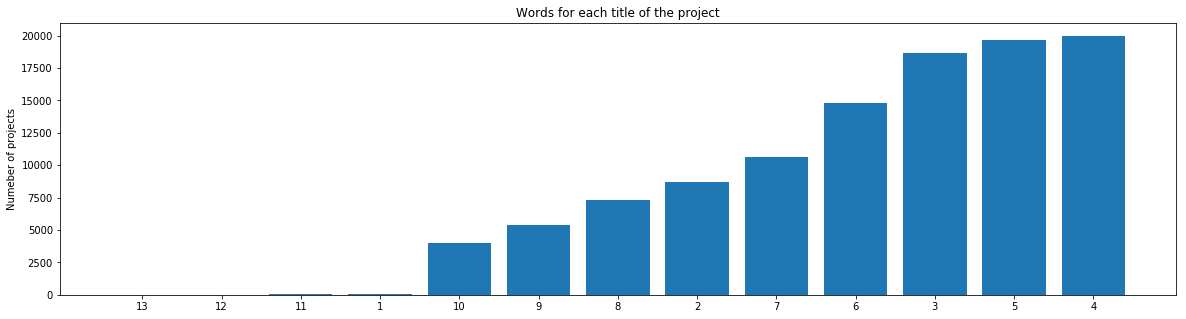

In [170]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Numeber of projects')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In [0]:
approved_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

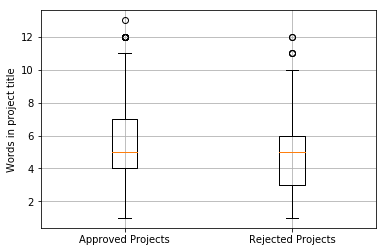

In [172]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

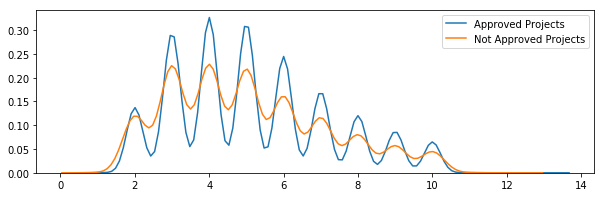

In [173]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.legend()
plt.show()

### 1.2.7 Univariate Analysis: Text features (Project Essay's)

In [0]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

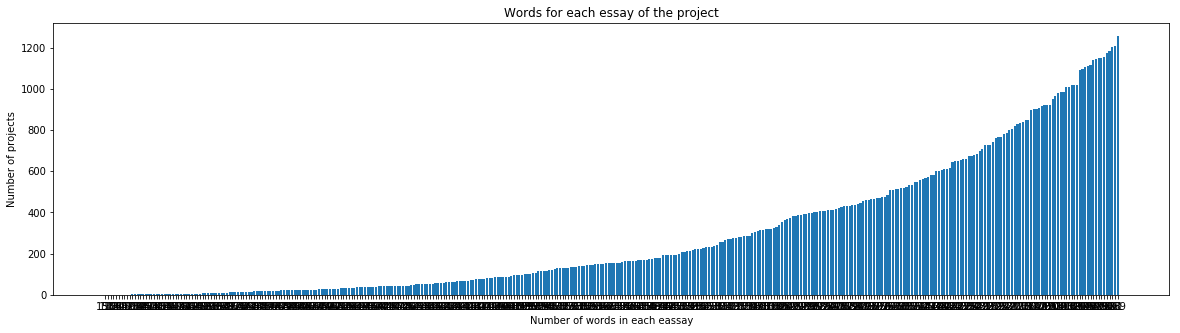

In [175]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['essay'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of projects')
plt.xlabel('Number of words in each eassay')
plt.title('Words for each essay of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

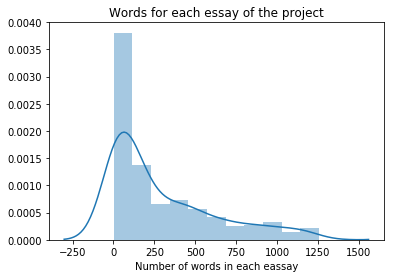

In [176]:
sns.distplot(word_count.values)
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.show()


In [0]:
approved_word_count = project_data[project_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = project_data[project_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

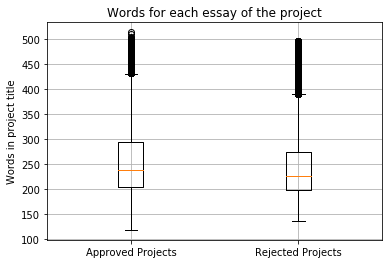

In [178]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

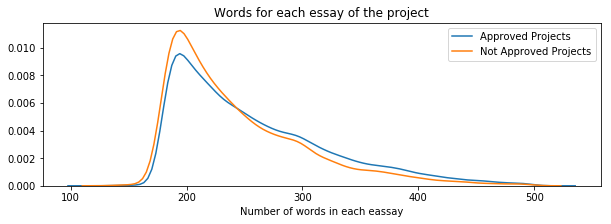

In [179]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

### 1.2.8 Univariate Analysis: Cost per project

In [180]:
# we get the cost of the project using resource.csv file
resource_data.head(2)

id                                        description  quantity   price
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1  149.00
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   14.95

In [181]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [0]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [0]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values

rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

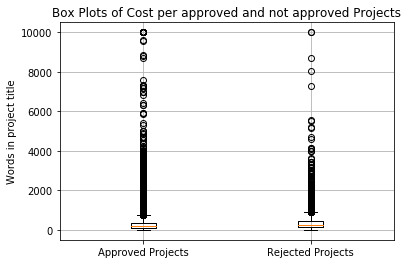

In [184]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

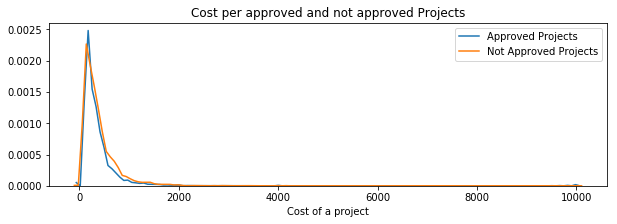

In [185]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

In [186]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

## 1.2.9 Univariate Analysis: teacher_number_of_previously_posted_projects</font></h3>

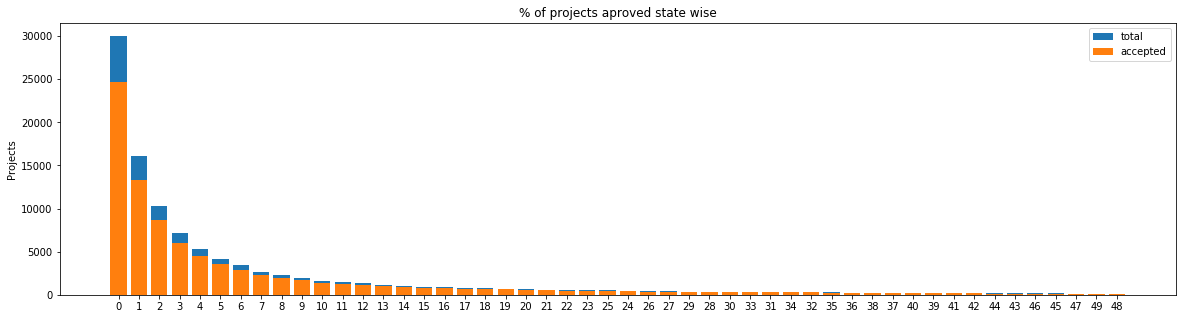

   teacher_number_of_previously_posted_projects  ...       Avg
0                                             0  ...  0.821350
1                                             1  ...  0.830054
2                                             2  ...  0.841063
3                                             3  ...  0.843460
4                                             4  ...  0.845423

[5 rows x 4 columns]
    teacher_number_of_previously_posted_projects  ...       Avg
46                                            46  ...  0.908537
45                                            45  ...  0.921569
47                                            47  ...  0.895833
49                                            49  ...  0.895105
48                                            48  ...  0.964286

[5 rows x 4 columns]


In [187]:
univariate_barplots(project_data, 'teacher_number_of_previously_posted_projects', 'project_is_approved', top=50)

## 1.2.10 Univariate Analysis: project_resource_summary</font></h3>

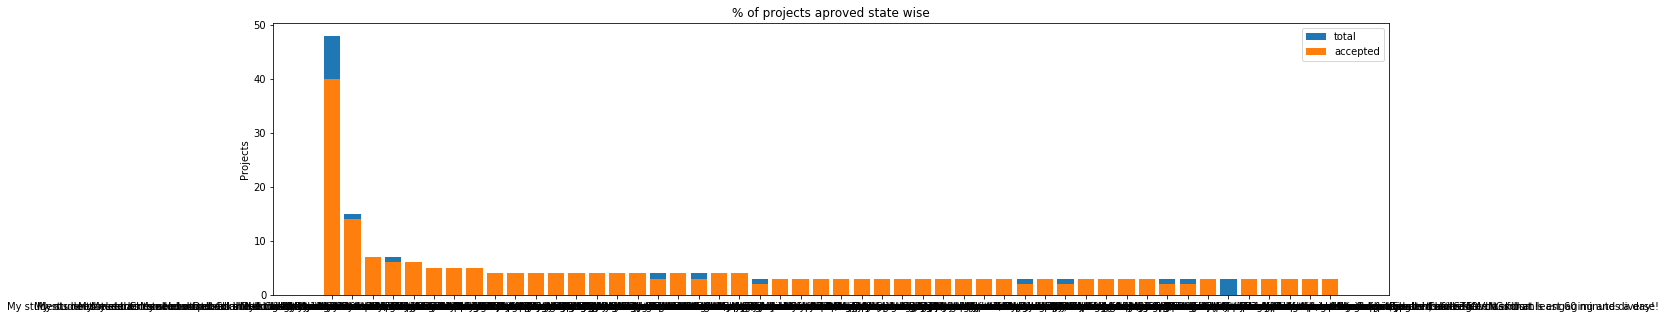

                                project_resource_summary  ...       Avg
56539  My students need electronic tablets to do all ...  ...  0.833333
10193  My students need Chromebooks to do all the thi...  ...  0.933333
18828  My students need a Dell Chromebook 3120 and a ...  ...  1.000000
51417  My students need chromebooks to do all the thi...  ...  0.857143
18819  My students need a Dell Chromebook 3120 11 6 C...  ...  1.000000

[5 rows x 4 columns]
                                project_resource_summary  ...  Avg
34033  My students need a variety of books for our cl...  ...  1.0
42108  My students need an iPad to be prepared for th...  ...  1.0
1705   My students need 2 Chromebooks, and 2 console ...  ...  1.0
7837   My students need 7 Hokki stools to get ACTIVE ...  ...  1.0
91743  My students need technology in the classroom. ...  ...  1.0

[5 rows x 4 columns]


In [188]:
univariate_barplots(project_data, 'project_resource_summary', 'project_is_approved', top=50)

# 2. Preprocessing Categorical Features: project_grade_category

In [189]:
project_data['project_grade_category'].value_counts()

Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: project_grade_category, dtype: int64

we need to remove the spaces, replace the '-' with '_' and convert all the letters to small

In [190]:
# https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
project_data['project_grade_category'].value_counts()

grades_prek_2    44225
grades_3_5       37137
grades_6_8       16923
grades_9_12      10963
Name: project_grade_category, dtype: int64

In [191]:
project_data.head(2)

Unnamed: 0       id  ...  price quantity
0      160221  p253737  ...  154.6       23
1      140945  p258326  ...  299.0        1

[2 rows x 20 columns]

# 3. Preprocessing Categorical Features: clean_categories

In [192]:
project_data['clean_categories'].value_counts()

Literacy_Language                       23655
Math_Science                            17072
Literacy_Language Math_Science          14636
Health_Sports                           10177
Music_Arts                               5180
SpecialNeeds                             4226
Literacy_Language SpecialNeeds           3961
AppliedLearning                          3771
Math_Science Literacy_Language           2289
AppliedLearning Literacy_Language        2191
History_Civics                           1851
Math_Science SpecialNeeds                1840
Literacy_Language Music_Arts             1757
Math_Science Music_Arts                  1642
AppliedLearning SpecialNeeds             1467
History_Civics Literacy_Language         1421
Health_Sports SpecialNeeds               1391
Warmth Care_Hunger                       1309
Math_Science AppliedLearning             1220
AppliedLearning Math_Science             1052
Literacy_Language History_Civics          809
Health_Sports Literacy_Language   

>remove spaces, 'the' <br>
replace '&' with '\_', and ',' with '_'

In [193]:
project_data['clean_categories'] = project_data['clean_categories'].str.replace(' The ','')
project_data['clean_categories'] = project_data['clean_categories'].str.replace(' ','')
project_data['clean_categories'] = project_data['clean_categories'].str.replace('&','_')
project_data['clean_categories'] = project_data['clean_categories'].str.replace(',','_')
project_data['clean_categories'] = project_data['clean_categories'].str.lower()
project_data['clean_categories'].value_counts()

literacy_language                     23655
math_science                          17072
literacy_languagemath_science         14636
health_sports                         10177
music_arts                             5180
specialneeds                           4226
literacy_languagespecialneeds          3961
appliedlearning                        3771
math_scienceliteracy_language          2289
appliedlearningliteracy_language       2191
history_civics                         1851
math_sciencespecialneeds               1840
literacy_languagemusic_arts            1757
math_sciencemusic_arts                 1642
appliedlearningspecialneeds            1467
history_civicsliteracy_language        1421
health_sportsspecialneeds              1391
warmthcare_hunger                      1309
math_scienceappliedlearning            1220
appliedlearningmath_science            1052
literacy_languagehistory_civics         809
health_sportsliteracy_language          803
appliedlearningmusic_arts       

# 4. Preprocessing Categorical Features: teacher_prefix

In [194]:
project_data['teacher_prefix'].value_counts()

Mrs.       57269
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64

In [195]:
# check if we have any nan values are there
print(project_data['teacher_prefix'].isnull().values.any())
print("number of nan values",project_data['teacher_prefix'].isnull().values.sum())

True
number of nan values 3


>numebr of missing values are very less in number, we can replace it with Mrs. as most of the projects are submitted by Mrs.

In [0]:
project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('Mrs.')

In [197]:
project_data['teacher_prefix'].value_counts()

Mrs.       57272
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64

>Remove '.' <br>
>convert all the chars to small

In [198]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()
project_data['teacher_prefix'].value_counts()

mrs        57272
ms         38955
mr         10648
teacher     2360
dr            13
Name: teacher_prefix, dtype: int64

# 5. Preprocessing Categorical Features: clean_subcategories

In [199]:
project_data['clean_subcategories'].value_counts()

Literacy                                   9486
Literacy Mathematics                       8325
Literature_Writing Mathematics             5923
Literacy Literature_Writing                5571
Mathematics                                5379
Literature_Writing                         4501
SpecialNeeds                               4226
Health_Wellness                            3583
AppliedSciences Mathematics                3399
AppliedSciences                            2492
Literacy SpecialNeeds                      2440
Gym_Fitness Health_Wellness                2264
ESL Literacy                               2234
VisualArts                                 2217
Music                                      1472
Warmth Care_Hunger                         1309
Literature_Writing SpecialNeeds            1306
Gym_Fitness                                1195
Health_Wellness SpecialNeeds               1189
Mathematics SpecialNeeds                   1187
EnvironmentalScience                    

> same process we did in project_subject_categories

In [200]:
project_data['clean_subcategories'] = project_data['clean_subcategories'].str.replace(' The ','')
project_data['clean_subcategories'] = project_data['clean_subcategories'].str.replace(' ','')
project_data['clean_subcategories'] = project_data['clean_subcategories'].str.replace('&','_')
project_data['clean_subcategories'] = project_data['clean_subcategories'].str.replace(',','_')
project_data['clean_subcategories'] = project_data['clean_subcategories'].str.lower()
project_data['clean_subcategories'].value_counts()

literacy                                  9486
literacymathematics                       8325
literature_writingmathematics             5923
literacyliterature_writing                5571
mathematics                               5379
literature_writing                        4501
specialneeds                              4226
health_wellness                           3583
appliedsciencesmathematics                3399
appliedsciences                           2492
literacyspecialneeds                      2440
gym_fitnesshealth_wellness                2264
eslliteracy                               2234
visualarts                                2217
music                                     1472
warmthcare_hunger                         1309
literature_writingspecialneeds            1306
gym_fitness                               1195
health_wellnessspecialneeds               1189
mathematicsspecialneeds                   1187
environmentalscience                      1079
teamsports   

# 6. Preprocessing Categorical Features: school_state

In [201]:
project_data['school_state'].value_counts()

CA    15388
TX     7396
NY     7318
FL     6185
NC     5091
IL     4350
GA     3963
SC     3936
MI     3161
PA     3109
IN     2620
MO     2576
OH     2467
LA     2394
MA     2389
WA     2334
OK     2276
NJ     2237
AZ     2147
VA     2045
WI     1827
AL     1762
UT     1731
TN     1688
CT     1663
MD     1514
NV     1367
MS     1323
KY     1304
OR     1242
MN     1208
CO     1111
AR     1049
ID      693
IA      666
KS      634
NM      557
DC      516
HI      507
ME      505
WV      503
NH      348
AK      345
DE      343
NE      309
SD      300
RI      285
MT      245
ND      143
WY       98
VT       80
Name: school_state, dtype: int64

>convert all of them into small letters

In [202]:
project_data['school_state'] = project_data['school_state'].str.lower()
project_data['school_state'].value_counts()

ca    15388
tx     7396
ny     7318
fl     6185
nc     5091
il     4350
ga     3963
sc     3936
mi     3161
pa     3109
in     2620
mo     2576
oh     2467
la     2394
ma     2389
wa     2334
ok     2276
nj     2237
az     2147
va     2045
wi     1827
al     1762
ut     1731
tn     1688
ct     1663
md     1514
nv     1367
ms     1323
ky     1304
or     1242
mn     1208
co     1111
ar     1049
id      693
ia      666
ks      634
nm      557
dc      516
hi      507
me      505
wv      503
nh      348
ak      345
de      343
ne      309
sd      300
ri      285
mt      245
nd      143
wy       98
vt       80
Name: school_state, dtype: int64

# 7. Preprocessing Categorical Features: project_title

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [205]:
project_data['project_title'].head(5)

0     Educational Support for English Learners at Home
1                Wanted: Projector for Hungry Learners
2    Soccer Equipment for AWESOME Middle School Stu...
3                               Techie Kindergarteners
4                               Interactive Math Tools
Name: project_title, dtype: object

In [206]:
print("printing some random reviews")
print(9, project_data['project_title'].values[9])
print(34, project_data['project_title'].values[34])
print(147, project_data['project_title'].values[147])

printing some random reviews
9 Just For the Love of Reading--\r\nPure Pleasure
34 \"Have A Ball!!!\"
147 Who needs a Chromebook?\r\nWE DO!!


In [0]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [208]:
preprocessed_titles = preprocess_text(project_data['project_title'].values)

100%|██████████| 109248/109248 [00:02<00:00, 43031.42it/s]


In [209]:
print("printing some random reviews")
print(9, preprocessed_titles[9])
print(34, preprocessed_titles[34])
print(147, preprocessed_titles[147])

printing some random reviews
9 love reading pure pleasure
34 ball
147 needs chromebook


# 8. Preprocessing Categorical Features: essay

In [0]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [211]:
print("printing some random essay")
print(9, project_data['essay'].values[9])
print('-'*50)
print(34, project_data['essay'].values[34])
print('-'*50)
print(147, project_data['essay'].values[147])

printing some random essay
9 Over 95% of my students are on free or reduced lunch.  I have a few who are homeless, but despite that, they come to school with an eagerness to learn.  My students are inquisitive eager learners who  embrace the challenge of not having great books and other resources  every day.  Many of them are not afforded the opportunity to engage with these big colorful pages of a book on a regular basis at home and they don't travel to the public library.  \r\nIt is my duty as a teacher to do all I can to provide each student an opportunity to succeed in every aspect of life. \r\nReading is Fundamental! My students will read these books over and over again while boosting their comprehension skills. These books will be used for read alouds, partner reading and for Independent reading. \r\nThey will engage in reading to build their \"Love for Reading\" by reading for pure enjoyment. They will be introduced to some new authors as well as some old favorites. I want my st

In [212]:
preprocessed_essays = preprocess_text(project_data['essay'].values)

100%|██████████| 109248/109248 [00:57<00:00, 1899.81it/s]


In [213]:
print("printing some random essay")
print(9, preprocessed_essays[9])
print('-'*50)
print(34, preprocessed_essays[34])
print('-'*50)
print(147, preprocessed_essays[147])

printing some random essay
9 95 students free reduced lunch homeless despite come school eagerness learn students inquisitive eager learners embrace challenge not great books resources every day many not afforded opportunity engage big colorful pages book regular basis home not travel public library duty teacher provide student opportunity succeed every aspect life reading fundamental students read books boosting comprehension skills books used read alouds partner reading independent reading engage reading build love reading reading pure enjoyment introduced new authors well old favorites want students ready 21st century know pleasure holding good hard back book hand nothing like good book read students soar reading consideration generous funding contribution help build stamina prepare 3rd grade thank much reading proposal nannan
--------------------------------------------------
34 students mainly come extremely low income families majority come homes parents work full time students s

In [214]:
project_data.head(1)

Unnamed: 0       id  ...  price quantity
0      160221  p253737  ...  154.6       23

[1 rows x 20 columns]

# 9. Preprocessing Numerical Values: price

In [215]:
project_data.head(1)

Unnamed: 0       id  ...  price quantity
0      160221  p253737  ...  154.6       23

[1 rows x 20 columns]

In [216]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [217]:
project_data.head(1)

Unnamed: 0       id  ...  price quantity
0      160221  p253737  ...  154.6       23

[1 rows x 20 columns]

In [218]:
project_data['price'].head()

0    154.60
1    299.00
2    516.85
3    232.90
4     67.98
Name: price, dtype: float64

## 9.1 applying StandardScaler

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(project_data['price'].values.reshape(-1, 1))
project_data['std_price']=scaler.transform(project_data['price'].values.reshape(-1, 1) )

In [220]:
project_data['std_price'].head()

0   -0.390533
1    0.002396
2    0.595191
3   -0.177469
4   -0.626236
Name: std_price, dtype: float64

## 9.2 applying MinMaxScaler

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(project_data['price'].values.reshape(-1, 1))
project_data['nrm_price']=scaler.transform(project_data['price'].values.reshape(-1, 1))

In [222]:
project_data['nrm_price'].head()

0    0.015397
1    0.029839
2    0.051628
3    0.023228
4    0.006733
Name: nrm_price, dtype: float64

In [223]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'std_price', 'nrm_price'],
      dtype='object')

In [224]:
# printing some random essays.
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])


My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [0]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [226]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [227]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [228]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [230]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:57<00:00, 1890.18it/s]


In [231]:
# after preprocesing
preprocessed_essays[2000]

'describing students not easy task many would say inspirational creative hard working they unique unique interests learning abilities much what common desire learn day despite difficulties encounter our classroom amazing understand everyone learns pace as teacher i pride making sure students always engaged motivated inspired create learning this project help students choose seating appropriate developmentally many students tire sitting chairs lessons different seats available helps keep engaged learning flexible seating important classroom many students struggle attention focus engagement we currently stability balls seating well regular chairs stools help students trouble balance find difficult sit stability ball long period time we excited try stools part engaging classroom community nannan'

In [0]:
project_data['cleaned_text'] = preprocessed_essays

In [233]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'std_price', 'nrm_price', 'cleaned_text'],
      dtype='object')

# Model -1

In [0]:
# We split our dataset into train,cross-validation and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(project_data, project_data['project_is_approved'], stratify=target,test_size=0.30,random_state=123)

In [0]:
# Preparing Text Data As per Our Model

X_train["len_text"] = X_train["clean_text"].apply(len)
X_test["len_text"] = X_test["clean_text"].apply(len)

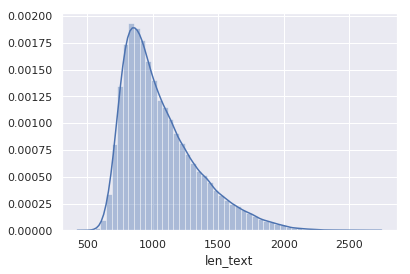

In [0]:
sns.set()
ax = sns.distplot(X_train["len_text"])

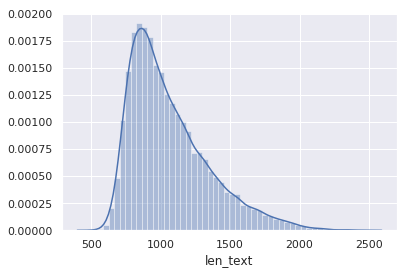

In [0]:
ax = sns.distplot(X_test["len_text"])

In [0]:
MAX_SEQUENCE_LENGTH = 800
MAX_VOCAB_SIZE = 1000000
EMBEDDING_DIM = 300

In [0]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train["clean_text"].tolist())
sequences_train = tokenizer.texts_to_sequences(X_train["clean_text"])
sequences_test = tokenizer.texts_to_sequences(X_test["clean_text"])

In [0]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 49064 unique tokens.


In [0]:
encoded_train = pad_sequences(sequences_train,maxlen=MAX_SEQUENCE_LENGTH,padding='post', truncating='post')
print('Shape of data tensor:', encoded_train.shape)

Shape of data tensor: (76473, 800)


In [0]:
encoded_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH,padding='post', truncating='post')
print('Shape of data tensor:', encoded_test.shape)

Shape of data tensor: (32775, 800)


In [0]:
# Loading Embedding File

pickle_in = open("/content/drive/My Drive/Colab Notebooks/glove_vectors","rb")
glove_words = pickle.load(pickle_in)

In [0]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, 300))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = glove_words.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector



In [0]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  300,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)
inputs_1 = Input(shape=(MAX_SEQUENCE_LENGTH,))

embedding_1 = embedding_layer(inputs_1)
lstm_1 = LSTM(128,recurrent_dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(embedding_1) 
flat_1 = Flatten()(lstm_1)











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Now will prepare all the remaining categorical features
# Teacher Prefix
no_of_unique_prefix  = X_train["teacher_prefix"].nunique()
embedding_size_prefix = int(min(np.ceil((no_of_unique_prefix)/2), 50 ))
print('Unique Categories:', no_of_unique_prefix,'Embedding Size:', embedding_size_prefix)


# Defining Input and Embedding Layer for the same

input_prefix = Input(shape=(1,),name="teacher_prefix")
embedding_prefix = Embedding(no_of_unique_prefix,embedding_size_prefix,name="emb_pre",trainable=True)(input_prefix)
flat_2 = Flatten()(embedding_prefix)

lb = LabelEncoder()
encoder_prefix_train = lb.fit_transform(X_train["teacher_prefix"])
encoder_prefix_test = lb.transform(X_test["teacher_prefix"])

Unique Categories: 5 Embedding Size: 3


In [0]:
# School State
no_of_unique_state  = X_train["school_state"].nunique()
embedding_size_state= int(min(np.ceil((no_of_unique_state)/2), 50 ))
print('Unique Categories:', no_of_unique_state,'Embedding Size:', embedding_size_state)


# Defining Input and Embedding Layer for the same

input_state = Input(shape=(1,),name="school_prefix")
embedding_state = Embedding(no_of_unique_state,embedding_size_state,name="emb_state",trainable=True)(input_state)
flat_3 = Flatten()(embedding_state)


encoder_state_train = lb.fit_transform(X_train["school_state"])
encoder_state_test = lb.transform(X_test["school_state"])

Unique Categories: 51 Embedding Size: 26


In [0]:
# For project_grade_category
no_of_unique_grade  = X_train["project_grade_category"].nunique()
embedding_size_grade = int(min(np.ceil((no_of_unique_grade)/2), 50 ))
print('Unique Categories:', no_of_unique_grade,'Embedding Size:', embedding_size_grade)


# Defining Input and Embedding Layer for the same

input_grade= Input(shape=(1,),name="grade_cat")
embedding_grade = Embedding(no_of_unique_grade,embedding_size_grade,name="emb_grade",trainable=True)(input_grade)
flat_4 = Flatten()(embedding_grade)


encoder_grade_train = lb.fit_transform(X_train["project_grade_category"])
encoder_grade_test = lb.transform(X_test["project_grade_category"])

Unique Categories: 4 Embedding Size: 2


In [0]:
# For project_subject_categories
no_of_unique_subcat  = X_train["clean_categories"].nunique()
embedding_size_subcat = int(min(np.ceil((no_of_unique_subcat)/2), 50 ))
print('Unique Categories:', no_of_unique_subcat,'Embedding Size:', embedding_size_subcat)


# Defining Input and Embedding Layer for the same

input_subcat= Input(shape=(1,),name="sub_cat")
embedding_subcat = Embedding(no_of_unique_subcat,embedding_size_subcat,name="emb_subcat",trainable=True)(input_subcat)
flat_5 = Flatten()(embedding_subcat)



le = LabelEncoder()
le.fit(X_train["clean_categories"])

encoder_subcat_train = le.transform(X_train["clean_categories"])
encoder_subcat_test= le.transform(X_test["clean_categories"])

Unique Categories: 51 Embedding Size: 26


In [0]:
# For project_subject_subcategories
no_of_unique_subcat_1  = X_train["clean_subcategories"].nunique()
embedding_size_subcat_1 = int(min(np.ceil((no_of_unique_subcat_1)/2), 50 ))
print('Unique Categories:', no_of_unique_subcat_1,'Embedding Size:', embedding_size_subcat_1)


input_subcat_1= Input(shape=(1,),name="sub_cat_1")
embedding_subcat_1 = Embedding(no_of_unique_subcat_1,embedding_size_subcat_1,name="emb_subcat_1",trainable=True)(input_subcat_1)
flat_6 = Flatten()(embedding_subcat_1)


le = LabelEncoder()
le.fit(X_train["clean_subcategories"])

encoder_subcat_1_train = le.transform(X_train["clean_subcategories"])
encoder_subcat_1_test= le.transform(X_test["clean_subcategories"])

Unique Categories: 391 Embedding Size: 50


In [0]:
# Now we will prepare numerical features for our model
num_train_1 = X_train['price'].values.reshape(-1, 1)
num_train_2 = X_train['quantity'].values.reshape(-1, 1)
num_train_3 = X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

num_test_1 = X_test['price'].values.reshape(-1, 1)
num_test_2 = X_test['quantity'].values.reshape(-1, 1)
num_test_3 = X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)


num_train=np.concatenate((num_train_1,num_train_2,num_train_3),axis=1)

num_test=np.concatenate((num_test_1,num_test_2,num_test_3),axis=1)


In [0]:
from sklearn.preprocessing import StandardScaler
norm=StandardScaler()
norm_train=norm.fit_transform(num_train)
norm_test=norm.transform(num_test)

In [0]:
# Defining the Input and Embedding Layer for the same

num_feats = Input(shape=(3,),name="numerical_features")
num_feats_ = Dense(100,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(num_feats)

In [0]:
print("Building Model-1")
merged = concatenate([flat_1,flatten_2,flatten_3,flatten_4,flatten_5,flatten_6,num_feats_])
# x_concatenate = BatchNormalization()(x_concatenate)
dense_1 = Dense(128,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(merged)
drop_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(256,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(drop_1)
drop_2 = Dropout(0.5)(dense_2)
dense_3 = Dense(64,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(drop_2)
batch_1 = BatchNormalization()(dense_3)
output = Dense(2, activation='softmax', name='output')(batch_1)
model_1 = Model(inputs=[inputs_1,input_prefix,input_state,input_grade,
                        input_subcat,input_subcat_1,num_feats],outputs=[output])

Building Model-1


In [0]:
train_data = [encoded_train,encoder_prefix_train,encoder_state_train,
              encoder_grade_train,encoder_subcat_train,encoder_subcat_1_train,norm_train]
test_data = [encoded_test,encoder_prefix_test,encoder_state_test,encoder_grade_test,
             encoder_subcat_test,encoder_subcat_1_test,norm_test]

from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, 2) 
Y_test = np_utils.to_categorical(y_test, 2)

In [0]:

checkpoint = ModelCheckpoint("model_3.h5",
                             monitor="val_auroc",
                             mode="max",
                             save_best_only = True,
                             verbose=1)


tensorboard = TensorBoard(log_dir='graph_3', histogram_freq=0, batch_size=512, write_graph=True, write_grads=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

callbacks = [tensorboard,checkpoint]

In [0]:
# Defining Custom ROC-AUC Metrics
from sklearn.metrics import roc_auc_score

def auc1(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred)

def auc(y_true, y_pred):
    return tf.py_func(auc1, (y_true, y_pred), tf.double)

In [0]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
rms = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
# ,clipvalue=0.4

In [0]:
#model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[auc])
model_1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[auc])



Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [0]:
history_1 = model_1.fit(train_data,Y_train,batch_size=1000,
                        epochs=20,validation_data=(test_data,Y_test),callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 76473 samples, validate on 32775 samples


Epoch 1/20
76473/76473 [==============================] - 243s 3ms/step - loss: 1.6430 - auc: 0.5140 - val_loss: 1.2102 - val_auc: 0.5811

Epoch 2/20
76473/76473 [==============================] - 239s 3ms/step - loss: 1.0013 - auc: 0.5347 - val_loss: 0.8842 - val_auc: 0.6765
Epoch 3/20
76473/76473 [==============================] - 239s 3ms/step - loss: 0.7869 - auc: 0.6612 - val_loss: 0.7668 - val_auc: 0.7211
Epoch 4/20
76473/76473 [==============================] - 238s 3ms/step - loss: 0.6637 - auc: 0.7223 - val_loss: 0.6620 - val_auc: 0.7397
Epoch 5/20
76473/76473 [==============================] - 236s 3ms/step - loss: 0.5884 - auc: 0.7392 - val_loss: 0.5931 - val_auc: 0.7499
Epoch 6/20
76473/76473 [==============================] - 237s 3ms/step - loss: 0.5425 - auc: 0.7500 - val_loss: 0.5546 - val_auc: 0.7570
Epoch 7/20
76473/76473 

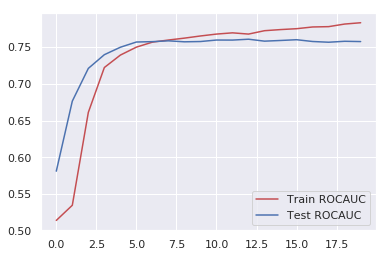

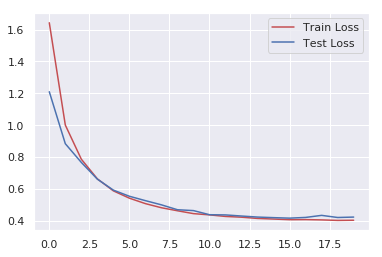

In [0]:
plt.plot(history_1.history['auc'], 'r')
plt.plot(history_1.history['val_auc'], 'b')
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})
plt.show()


plt.plot(history_1.history['loss'], 'r')
plt.plot(history_1.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

# Model - 2

In [0]:
#split the data as train and test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(project_data, project_data["project_is_approved"], test_size=0.25)

In [0]:
print("The shape of train data", x_train.shape)
print("The shape of test data ", x_test.shape)

The shape of train data (81936, 23)
The shape of test data  (27312, 23)


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
tf_idf_vect = TfidfVectorizer()
tf_idf_vect.fit(x_train["cleaned_text"])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)


some sample features(unique words in the corpus) ['00', '000', '001', '002', '003', '005nannan', '00am', '00pm', '01', '01075rm']


In [0]:
vocualbary=tf_idf_vect.get_feature_names()

idf = tf_idf_vect.idf_

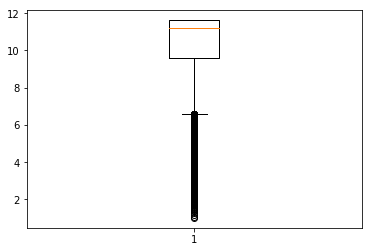

In [0]:
import matplotlib.pyplot as plt
 
box_plot_data=[ idf ]
plt.boxplot(box_plot_data)
plt.show()

In [0]:
print(dict(zip(vocualbary,idf)))

{'00': 7.219955737468623, '000': 5.91013174034057, '001': 11.215093649607276, '002': 11.62055875771544, '003': 11.62055875771544, '005nannan': 11.62055875771544, '00am': 10.116481360939165, '00pm': 9.828799288487385, '01': 10.367795789220072, '01075rm': 11.62055875771544, '01g': 11.215093649607276, '01ip': 11.215093649607276, '02': 10.704268025841285, '021': 11.62055875771544, '022x10': 11.62055875771544, '024': 11.62055875771544, '025': 11.62055875771544, '03': 10.367795789220072, '030': 11.215093649607276, '034': 11.62055875771544, '04': 10.927411577155494, '041': 11.62055875771544, '05': 10.52194646904733, '050': 10.927411577155494, '059': 11.62055875771544, '05a': 11.62055875771544, '05pm': 11.62055875771544, '06': 10.927411577155494, '060': 11.62055875771544, '07': 11.215093649607276, '074': 11.62055875771544, '077': 11.62055875771544, '08': 10.52194646904733, '084': 11.62055875771544, '09': 10.704268025841285, '0mp': 11.62055875771544, '0my': 11.62055875771544, '0nly': 11.6205587

In [0]:
d=dict(zip(vocualbary,idf))
previous_vocabulary=d.keys()
print(previous_vocabulary)
high_idf= 10
print("high_idf: ",high_idf)
low_idf= 2
print("low_idf: ",low_idf)
final_vocabulary=[]
for k in d:
    if(d[k]<=high_idf and d[k]>=low_idf ):
       final_vocabulary.append(k)
print(final_vocabulary)

dict_keys(['00', '000', '001', '002', '003', '005nannan', '00am', '00pm', '01', '01075rm', '01g', '01ip', '02', '021', '022x10', '024', '025', '03', '030', '034', '04', '041', '05', '050', '059', '05a', '05pm', '06', '060', '07', '074', '077', '08', '084', '09', '0mp', '0my', '0nly', '0thanks', '0the', '0ver', '10', '100', '1000', '1000blackgirlbooks', '1000s', '10027', '1009', '100cm', '100ft', '100m', '100s', '100th', '101', '102', '1020', '1022', '103', '104', '1043', '105', '1057', '106', '107', '1070', '1077', '108', '1080p', '1082', '1084', '109', '10am', '10cm', '10k', '10min', '10pk', '10pm', '10s', '10th', '10the', '10u', '10x', '10x10', '10yrs', '11', '110', '1100', '11000', '1104', '110mph', '111', '111558', '112', '1120', '112th', '113', '1130', '113th', '114', '115', '1150', '116', '117', '1170l', '119', '11e', '11pm', '11th', '11x14', '11x17', '11x25', '12', '120', '1200', '1202', '120s', '120th', '121', '1212', '122', '123', '1233', '1238', '123d', '123s', '124', '1248',

In [0]:
len(final_vocabulary)

14873

In [0]:
EMBEDDING_DIM = 300

In [0]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words = 300)
tokenizer.fit_on_texts(final_vocabulary)
text_train = tokenizer.texts_to_sequences(x_train["cleaned_text"])
text_test = tokenizer.texts_to_sequences(x_test["cleaned_text"])

In [0]:
max_words = 300 #more words for more accuracy
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(final_vocabulary)

text_train = tokenizer.texts_to_matrix(x_train["cleaned_text"], mode='binary')
text_test = tokenizer.texts_to_matrix(x_test["cleaned_text"], mode='binary')

#text_test = tokenizer.texts_to_matrix((x_test["cleaned_text"], mode='binary')
print(text_train.shape)
print(text_test.shape)

(81936, 300)
(27312, 300)


In [0]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 14873 unique tokens.


In [0]:
# Loading Embedding File

pickle_in = open("/content/drive/My Drive/Colab Notebooks/glove_vectors","rb")
glove_words = pickle.load(pickle_in)

In [0]:
num_words = len(word2idx) + 1
embedding_matrix = np.zeros((num_words, 300))
for word, i in word2idx.items():
  if i < len(final_vocabulary):
    embedding_vector = glove_words.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

In [0]:
print("The Number of words ",num_words)
print("The shapoe of embedding_matrix ", embedding_matrix.shape)

The Number of words  14874
The shapoe of embedding_matrix  (14874, 300)


In [0]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  300,
  weights=[embedding_matrix],
  input_length=300,
  trainable=False
)
inputs_1 = Input(shape=(300,),name="input_text")
embedding_1 = embedding_layer(inputs_1)
# x = SpatialDropout1D(0.4)(x)
lstm_1 =  LSTM(100,recurrent_dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(embedding_1) # dropout=0.5
flat_1 = Flatten()(lstm_1)

In [0]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'std_price', 'nrm_price', 'cleaned_text'],
      dtype='object')

In [0]:
# Now will prepare all the remaining categorical features
# Teacher Prefix
no_of_unique_prefix  = x_train["teacher_prefix"].nunique()
embedding_size_prefix = int(min(np.ceil((no_of_unique_prefix)/2), 50 ))
print('Unique Categories:', no_of_unique_prefix,'Embedding Size:', embedding_size_prefix)


# Defining Input and Embedding Layer for the same

input_prefix = Input(shape=(1,),name="teacher_prefix")
embedding_prefix = Embedding(no_of_unique_prefix,embedding_size_prefix,name="emb_pre",trainable=True)(input_prefix)
flatten_2 = Flatten()(embedding_prefix)

lb = LabelEncoder()
encoder_prefix_train = lb.fit_transform(x_train["teacher_prefix"])
encoder_prefix_test = lb.transform(x_test["teacher_prefix"])

Unique Categories: 5 Embedding Size: 3


In [0]:
# School State
no_of_unique_state  = x_train["school_state"].nunique()
embedding_size_state= int(min(np.ceil((no_of_unique_state)/2), 50 ))
print('Unique Categories:', no_of_unique_state,'Embedding Size:', embedding_size_state)


# Defining Input and Embedding Layer for the same

input_state = Input(shape=(1,),name="school_prefix")
embedding_state = Embedding(no_of_unique_state,embedding_size_state,name="emb_state",trainable=True)(input_state)
flatten_3 = Flatten()(embedding_state)


encoder_state_train = lb.fit_transform(x_train["school_state"])
encoder_state_test = lb.transform(x_test["school_state"])

Unique Categories: 51 Embedding Size: 26


In [0]:
# For project_grade_category
no_of_unique_grade  = x_train["project_grade_category"].nunique()
embedding_size_grade = int(min(np.ceil((no_of_unique_grade)/2), 50 ))
print('Unique Categories:', no_of_unique_grade,'Embedding Size:', embedding_size_grade)


# Defining Input and Embedding Layer for the same

input_grade= Input(shape=(1,),name="grade_cat")
embedding_grade = Embedding(no_of_unique_grade,embedding_size_grade,name="emb_grade",trainable=True)(input_grade)
flatten_4 = Flatten()(embedding_grade)


encoder_grade_train = lb.fit_transform(x_train["project_grade_category"])
encoder_grade_test = lb.transform(x_test["project_grade_category"])

Unique Categories: 4 Embedding Size: 2


In [0]:
# For project_subject_categories
no_of_unique_subcat  = x_train["clean_categories"].nunique()
embedding_size_subcat = int(min(np.ceil((no_of_unique_subcat)/2), 50 ))
print('Unique Categories:', no_of_unique_subcat,'Embedding Size:', embedding_size_subcat)


# Defining Input and Embedding Layer for the same

input_subcat= Input(shape=(1,),name="sub_cat")
embedding_subcat = Embedding(no_of_unique_subcat,embedding_size_subcat,name="emb_subcat",trainable=True)(input_subcat)
flatten_5 = Flatten()(embedding_subcat)

le = LabelEncoder()

encoder_subcat_train = le.fit_transform(x_train["clean_categories"])
encoder_subcat_test= le.fit_transform(x_test["clean_categories"])

Unique Categories: 51 Embedding Size: 26


In [0]:
# For project_subject_subcategories
no_of_unique_subcat_1  = x_train["clean_subcategories"].nunique()
embedding_size_subcat_1 = int(min(np.ceil((no_of_unique_subcat_1)/2), 50 ))
print('Unique Categories:', no_of_unique_subcat_1,'Embedding Size:', embedding_size_subcat_1)

# Defining Input and Embedding Layer for the same

input_subcat_1= Input(shape=(1,),name="sub_cat_1")
embedding_subcat_1 = Embedding(no_of_unique_subcat_1,embedding_size_subcat_1,name="emb_subcat_1",trainable=True)(input_subcat_1)
flatten_6 = Flatten()(embedding_subcat_1)


le = LabelEncoder()

encoder_subcat_1_train = le.fit_transform(x_train["clean_subcategories"])
encoder_subcat_1_test= le.fit_transform(x_test["clean_subcategories"])

Unique Categories: 392 Embedding Size: 50


In [0]:
# Now we will prepare numerical features for our model
num_train_1=x_train['price'].values.reshape(-1, 1)
num_train_2=x_train['quantity'].values.reshape(-1, 1)
num_train_3=x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

num_test_1=x_test['price'].values.reshape(-1, 1)
num_test_2=x_test['quantity'].values.reshape(-1, 1)
num_test_3=x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)


num_train=np.concatenate((num_train_1,num_train_2,num_train_3),axis=1)

num_test=np.concatenate((num_test_1,num_test_2,num_test_3),axis=1)


In [0]:
from sklearn.preprocessing import StandardScaler
norm=StandardScaler()
norm_train=norm.fit_transform(num_train)
norm_test=norm.transform(num_test)

In [0]:
# Defining the Input and Embedding Layer for the same

num_feats = Input(shape=(3,),name="numerical_features")
num_feats_ = Dense(100,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(num_feats)

In [10]:
print("Building Model-2")
merged = concatenate([flat_1,flatten_2,flatten_3,flatten_4,flatten_5,flatten_6,num_feats_])
# x_concatenate = BatchNormalization()(x_concatenate)
dense_1 = Dense(128,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(merged)
drop_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(256,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(drop_1)
drop_2 = Dropout(0.5)(dense_2)
dense_3 = Dense(64,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(drop_2)
batch_1 = BatchNormalization()(dense_3)
output = Dense(2, activation='softmax', name='output')(batch_1)
model-_2 = Model(inputs=[inputs_1,input_prefix,input_state,input_grade,
                        input_subcat,input_subcat_1,num_feats],outputs=[output])

Building Model-2


In [0]:
train_data = [text_train,encoder_prefix_train,encoder_state_train,
              encoder_grade_train,encoder_subcat_train,encoder_subcat_1_train,norm_train]
test_data = [text_test,encoder_prefix_test,encoder_state_test,encoder_grade_test,
             encoder_subcat_test,encoder_subcat_1_test,norm_test]

from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, 2) 
Y_test = np_utils.to_categorical(y_test, 2)

In [0]:

checkpoint = ModelCheckpoint("model_3.h5",
                             monitor="val_auroc",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

tensorboard_ = TensorBoard(log_dir='graph_3', histogram_freq=0, batch_size=512, write_graph=True, write_grads=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

callbacks = [tensorboard,checkpoint]

In [0]:
# Defining Custom ROC-AUC Metrics
from sklearn.metrics import roc_auc_score

def auc1(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred)

def auc(y_true, y_pred):
    return tf.py_func(auc1, (y_true, y_pred), tf.double)

In [0]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
rms = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
# ,clipvalue=0.4

In [0]:
#model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[auc])
model_2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[auc])

In [0]:
history_2 = model_2.fit(train_data,Y_train,batch_size=1000,
                        epochs=20,validation_data=(test_data,Y_test),callbacks=callbacks_3)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 87398 samples, validate on 21850 samples


Epoch 1/20
87398/87398 [==============================] - 71s 818us/step - loss: 1.4589 - auc: 0.5094 - val_loss: 0.9964 - val_auc: 0.6275

Epoch 2/20
87398/87398 [==============================] - 70s 798us/step - loss: 0.7881 - auc: 0.6214 - val_loss: 0.6827 - val_auc: 0.7168
Epoch 3/20
87398/87398 [==============================] - 70s 795us/step - loss: 0.6026 - auc: 0.7208 - val_loss: 0.5749 - val_auc: 0.7432
Epoch 4/20
87398/87398 [==============================] - 69s 793us/step - loss: 0.5200 - auc: 0.7443 - val_loss: 0.5123 - val_auc: 0.7510
Epoch 5/20
87398/87398 [==============================] - 69s 794us/step - loss: 0.4742 - auc: 0.7525 - val_loss: 0.4736 - val_auc: 0.7538
Epoch 6/20
87398/87398 [==============================] - 69s 794us/step - loss: 0.4463 - auc: 0.7568 - val_loss: 0.4525 - val_auc: 0.7581
Epoch 7/20
87398/

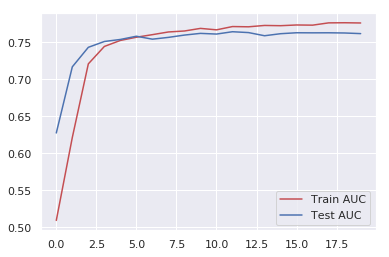

In [0]:
sns.set()
plt.plot(history_2.history['auc'], 'r')
plt.plot(history_2.history['val_auc'], 'b')
plt.legend({'Train AUC': 'r', 'Test AUC':'b'})
plt.show()


# Model - 3

In [0]:
#split the data as train and test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(project_data, project_data["project_is_approved"], test_size=0.25)

In [0]:
print("The shape of train data", x_train.shape)
print("The shape of test data ", x_test.shape)

The shape of train data (81936, 23)
The shape of test data  (27312, 23)


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
tf_idf_vect = TfidfVectorizer()
tf_idf_vect.fit(x_train["cleaned_text"])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)


some sample features(unique words in the corpus) ['00', '000', '001', '005nannan', '00am', '00p', '00pm', '01', '010', '01075rm']


In [0]:
vocualbary=tf_idf_vect.get_feature_names()

idf = tf_idf_vect.idf_

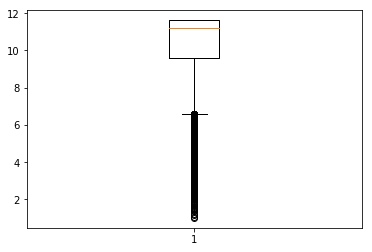

In [0]:
import matplotlib.pyplot as plt
 
box_plot_data=[ idf ]
plt.boxplot(box_plot_data)
plt.show()

In [0]:
print(dict(zip(vocualbary,idf)))

{'00': 7.160414343777607, '000': 5.887217480817695, '001': 11.62055875771544, '005nannan': 11.62055875771544, '00am': 10.234264396595549, '00p': 11.62055875771544, '00pm': 9.605655737173175, '01': 10.704268025841285, '010': 11.62055875771544, '01075rm': 11.62055875771544, '01g': 11.215093649607276, '01ip': 11.62055875771544, '02': 11.215093649607276, '021': 11.62055875771544, '022x10': 11.62055875771544, '025': 11.62055875771544, '02810010': 11.62055875771544, '03': 10.234264396595549, '0315': 11.62055875771544, '034': 11.62055875771544, '04': 10.927411577155494, '041': 11.62055875771544, '04112016': 11.62055875771544, '047': 11.62055875771544, '05': 10.116481360939165, '050': 10.927411577155494, '059': 11.62055875771544, '05pm': 11.62055875771544, '06': 11.215093649607276, '060': 11.62055875771544, '07': 11.62055875771544, '08': 10.704268025841285, '084': 11.62055875771544, '09': 10.927411577155494, '0mp': 11.62055875771544, '0the': 11.62055875771544, '0ver': 10.704268025841285, '10':

In [0]:
d=dict(zip(vocualbary,idf))
previous_vocabulary=d.keys()
print(previous_vocabulary)
high_idf= 10
print("high_idf: ",high_idf)
low_idf= 2
print("low_idf: ",low_idf)
final_vocabulary=[]
for k in d:
    if(d[k]<=high_idf and d[k]>=low_idf ):
       final_vocabulary.append(k)
print(final_vocabulary)

dict_keys(['00', '000', '001', '005nannan', '00am', '00p', '00pm', '01', '010', '01075rm', '01g', '01ip', '02', '021', '022x10', '025', '02810010', '03', '0315', '034', '04', '041', '04112016', '047', '05', '050', '059', '05pm', '06', '060', '07', '08', '084', '09', '0mp', '0the', '0ver', '10', '100', '1000', '1000blackgirlbooks', '1000s', '10027', '1009', '100cm', '100ft', '100m', '100s', '100th', '101', '1017', '102', '1020', '1022', '103', '104', '1043', '105', '1057', '106', '107', '1070', '1077', '108', '1080p', '1082', '1084', '109', '1099', '10am', '10cm', '10k', '10min', '10pk', '10pm', '10s', '10th', '10the', '10u', '10x', '10x10', '10yrs', '11', '110', '1100', '1104', '111', '111558', '111s', '112', '1120', '11242', '112th', '113', '1130', '113th', '114', '115', '116', '117', '1170l', '118', '11am', '11pm', '11th', '11x14', '11x17', '11x25', '12', '120', '1200', '12000', '1202', '120s', '120th', '121', '1212', '122', '122514', '123', '1233', '1238', '123d', '123s', '124', '12

In [0]:
len(final_vocabulary)

14872

In [0]:
# MAX_SEQUENCE_LENGTH = 800
# MAX_VOCAB_SIZE = 1000000
EMBEDDING_DIM = 300

In [0]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(final_vocabulary)
text_train = tokenizer.texts_to_sequences(x_train["cleaned_text"])
text_test = tokenizer.texts_to_sequences(x_test["cleaned_text"])

In [0]:
length = []

for i in text_train:

  length.append(len(i))

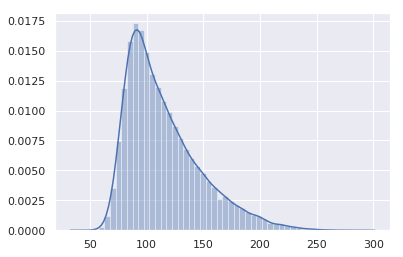

In [0]:
sns.set()
sns.distplot(length)

In [0]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 14872 unique tokens.


In [0]:
max_len_seq = 100

In [0]:
text_train = pad_sequences(text_train,maxlen=max_len_seq)
print('Shape of data tensor:', text_train.shape)

Shape of data tensor: (81936, 100)


In [0]:
text_test = pad_sequences(text_test, maxlen=max_len_seq)
print('Shape of data tensor:', text_test.shape)

Shape of data tensor: (27312, 100)


In [0]:
# Loading Embedding File

pickle_in = open("/content/drive/My Drive/Colab Notebooks/Donors for AFR Classroom/glove_vectors","rb")
glove_words = pickle.load(pickle_in)

In [0]:
num_words = len(word2idx) + 1
embedding_matrix = np.zeros((num_words, 300))
for word, i in word2idx.items():
  if i < len(final_vocabulary):
    embedding_vector = glove_words.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [0]:
print("The Number of words ",num_words)
print("The shapoe of embedding_matrix ", embedding_matrix.shape)

The Number of words  14873
The shapoe of embedding_matrix  (14873, 300)


In [0]:
from sklearn.preprocessing import OneHotEncoder

In [0]:
#cat_features
cat_feature_x_train_school_state = x_train['school_state'].values
cat_feature_x_train_teacher_prefix = x_train['teacher_prefix'].values
cat_feature_x_train_project_grade_category = x_train['project_grade_category'].values
cat_feature_x_train_clean_categories = x_train['clean_categories'].values
cat_feature_x_train_clean_subcategories =x_train['clean_subcategories'].values

cat_feature_x_test_school_state = x_test['school_state'].values
cat_feature_x_test_teacher_prefix = x_test['teacher_prefix'].values
cat_feature_x_test_project_grade_category = x_test['project_grade_category'].values
cat_feature_x_test_clean_categories = x_test['clean_categories'].values
cat_feature_x_test_clean_subcategories = x_test['clean_subcategories'].values

In [0]:
school_state = x_train['school_state'].values
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
school_state_train = school_state.reshape(-1, 1)
ohe.fit(school_state_train)
cat_feature_x_train_school_state = ohe.transform(school_state_train)
school_state_test = cat_feature_x_test_school_state.reshape(-1,1)
cat_feature_x_test_school_state = ohe.transform(school_state_test)

In [0]:
cat_feature_x_train_school_state.shape

(81936, 51)

In [0]:
train_teacher_prefix = cat_feature_x_train_teacher_prefix.reshape(-1,1)
test_teacher_prefix = cat_feature_x_test_teacher_prefix.reshape(-1,1)
ohe.fit(train_teacher_prefix)
cat_feature_x_train_teacher_prefix = ohe.transform(train_teacher_prefix)
cat_feature_x_test_teacher_prefix = ohe.transform(test_teacher_prefix)

In [0]:
cat_feature_x_train_teacher_prefix.shape

(81936, 5)

In [0]:
train_project_grade_category = cat_feature_x_train_project_grade_category.reshape(-1,1)
test_project_grade_category = cat_feature_x_test_project_grade_category.reshape(-1,1)
ohe.fit(train_project_grade_category)
cat_feature_x_train_project_grade_category = ohe.transform(train_project_grade_category)
cat_feature_x_test_project_grade_category = ohe.transform(test_project_grade_category)

In [0]:
train_clean_categories = cat_feature_x_train_clean_categories.reshape(-1,1)
test_clean_categories = cat_feature_x_test_clean_categories.reshape(-1,1)
ohe.fit(train_clean_categories)
cat_feature_x_train_clean_categories = ohe.transform(train_clean_categories)
cat_feature_x_test_clean_categories = ohe.transform(test_clean_categories)

In [0]:
train_clean_subcategories = cat_feature_x_train_clean_subcategories.reshape(-1,1)
test_clean_subcategories = cat_feature_x_test_clean_subcategories.reshape(-1,1)
ohe.fit(train_teacher_prefix)
cat_feature_x_train_clean_subcategories = ohe.transform(train_clean_subcategories)
cat_feature_x_test_clean_subcategories = ohe.transform(test_clean_subcategories)

In [0]:
cat_feat_train = np.hstack((cat_feature_x_train_school_state,cat_feature_x_train_teacher_prefix,cat_feature_x_train_project_grade_category,cat_feature_x_train_clean_categories,cat_feature_x_train_clean_subcategories))
cat_feat_test = np.hstack((cat_feature_x_test_school_state,cat_feature_x_test_teacher_prefix,cat_feature_x_test_project_grade_category,cat_feature_x_test_clean_categories,cat_feature_x_test_clean_subcategories))

In [0]:
cat_feat_train.shape

(81936, 116)

In [0]:
#target
target_x_train = 'project_is_approved'
target_x_test = 'project_is_approved'



#Numerical features
real_feature_x_train_price = ['price']
real_feature_x_train_quantity = ['quantity']
real_feature_x_train_teacher_number_of_previously_posted_projects = ['teacher_number_of_previously_posted_projects'] 

real_feature_x_test_price = ['price']
real_feature_x_test_quantity = ['quantity']
real_feature_x_test_teacher_number_of_previously_posted_projects = ['teacher_number_of_previously_posted_projects'] 

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
SS = StandardScaler()
SS.fit(x_train[real_feature_x_train_price])
x_train_real_feature_price_scale = SS.transform(x_train[real_feature_x_train_price])
x_test_real_feature_price_scale = SS.transform(x_test[real_feature_x_test_price])

In [0]:
SS.fit(x_train[real_feature_x_train_quantity])
x_train_real_feature_quantity_scale = SS.transform(x_train[real_feature_x_train_quantity])
x_test_real_feature_quantity_scale = SS.transform(x_test[real_feature_x_test_quantity])

In [0]:
SS.fit(x_train[real_feature_x_train_teacher_number_of_previously_posted_projects])
x_train_real_feature_teacher_number_of_previously_posted_projects_scale = SS.transform(x_train[real_feature_x_train_teacher_number_of_previously_posted_projects])
x_test_real_feature_teacher_number_of_previously_posted_projects_scale = SS.transform(x_test[real_feature_x_test_teacher_number_of_previously_posted_projects])

In [0]:
real_feature_x_train = np.concatenate((x_train_real_feature_price_scale,x_train_real_feature_quantity_scale,x_train_real_feature_teacher_number_of_previously_posted_projects_scale),axis = 1)
real_feature_x_test = np.concatenate((x_test_real_feature_price_scale,x_test_real_feature_quantity_scale,x_test_real_feature_teacher_number_of_previously_posted_projects_scale),axis = 1)

In [0]:
real_feature_x_train.shape

(81936, 3)

In [0]:
other_all_train = np.hstack((cat_feat_train,real_feature_x_train))
other_all_test = np.hstack((cat_feat_test,real_feature_x_test))

In [0]:
other_all_train.shape

(81936, 119)

In [0]:
other_train = np.expand_dims(other_all_train,2)
other_test = np.expand_dims(other_all_test,2)

In [0]:
print(other_train.shape)
print("++++++++++++++")
print(other_test.shape)

(81936, 119, 1)
++++++++++++++
(27312, 119, 1)


In [0]:
len_oth_train = other_all_train.shape[1]

In [0]:
len_oth_train

119

In [0]:

embedding_layer = Embedding(
  num_words,
  300,
  weights=[embedding_matrix],
  input_length=max_len_seq,
  trainable=False
)
inputs_1 = Input(shape=(max_len_seq,),name="input_text")
embedding_1 = embedding_layer(inputs_1)
# x = SpatialDropout1D(0.4)(x)
lstm_1 = LSTM(256,dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(embedding_1) # dropout=0.5
flat_1 = Flatten()(lstm_1)











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
inputs_2 = Input(shape=(len_oth_train,1))
conv_1 = Conv1D(filters=128, kernel_size=3, activation='relu',kernel_initializer="he_normal")(inputs_2)
conv_2 = Conv1D(filters=128, kernel_size=3, activation='relu',kernel_initializer="he_normal")(conv_1)

flat_2 = Flatten()(conv_2)

In [0]:
from keras.layers.merge import concatenate
merged = concatenate([flat_1, flat_2])

In [0]:
from keras.models import Model
# interpretation
dense1 = Dense(128,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(merged)
drop1 = Dropout(0.5)(dense1)

dense2 = Dense(64,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(drop1)
drop2 = Dropout(0.3)(dense2)

dense_3 = Dense(32,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(drop2)

outputs = Dense(2, activation='softmax', name='output')(dense_3)
model_3 = Model(inputs=(inputs_1, inputs_2), outputs=outputs)

model_3.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         (None, 100)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 119, 1)       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     4461900     input_text[0][0]                 
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 117, 128)     512         input_1[0][0]                    
____________________________________________________________________________________________

In [0]:
train_dat = [text_train,other_train]
test_data = [text_test,other_test]

from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, 2) 
Y_test = np_utils.to_categorical(y_test, 2)

In [0]:
other_train.shape

(81936, 119, 1)

In [0]:

checkpoint_3 = ModelCheckpoint("model_3.h5",
                             monitor="val_auroc",
                             mode="max",
                             save_best_only = True,
                             verbose=1)


tensorboard_3 = TensorBoard(log_dir='graph_3', histogram_freq=0, batch_size=512, write_graph=True, write_grads=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

callbacks_3 = [tensorboard_3,checkpoint_3]

In [0]:
# Defining Custom ROC-AUC Metrics
from sklearn.metrics import roc_auc_score

def auc1(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred)

def auc(y_true, y_pred):
    return tf.py_func(auc1, (y_true, y_pred), tf.double)

In [0]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
rms = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

In [0]:
model_3.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[auc])



Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [0]:
history_3 = model_3.fit([text_train,other_train],Y_train,batch_size=1000,
                        epochs=20,validation_data=([text_test,other_test],Y_test),callbacks=callbacks_3)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 81936 samples, validate on 27312 samples


Epoch 1/20
81936/81936 [==============================] - 839s 10ms/step - loss: 1.0128 - auc: 0.6200 - val_loss: 0.7172 - val_auc: 0.7300

Epoch 2/20
81936/81936 [==============================] - 829s 10ms/step - loss: 0.6333 - auc: 0.6918 - val_loss: 0.5771 - val_auc: 0.7353
Epoch 3/20
81936/81936 [==============================] - 830s 10ms/step - loss: 0.5363 - auc: 0.7048 - val_loss: 0.5231 - val_auc: 0.7392
Epoch 4/20
81936/81936 [==============================] - 825s 10ms/step - loss: 0.4869 - auc: 0.7166 - val_loss: 0.4784 - val_auc: 0.7471
Epoch 5/20
81936/81936 [==============================] - 818s 10ms/step - loss: 0.4570 - auc: 0.7255 - val_loss: 0.4566 - val_auc: 0.7539
Epoch 6/20
81936/81936 [==============================] - 821s 10ms/step - loss: 0.4363 - auc: 0.7345 - val_loss: 0.4382 - val_auc: 0.7575
Epoch 7/20
81936/

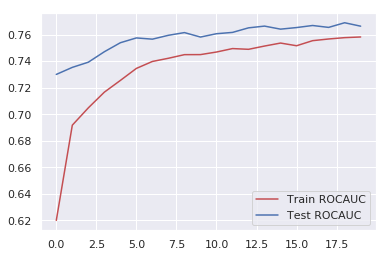

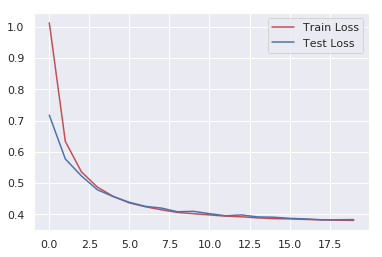

In [0]:
sns.set()
plt.plot(history_3.history['auc'], 'r')
plt.plot(history_3.history['val_auc'], 'b')
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})
plt.show()


plt.plot(history_3.history['loss'], 'r')
plt.plot(history_3.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

## Conclusion:

1. We take the data do some univariate anlysis and preprocessing steps

2. After the we split the data into train data and test data

3. We use AUC as metrics because this is highly imbalanced data set

4. After that we build three models. In model - 1 we apply LSTM layer on text feature, Embeding layer on categorical features and Dense layer on real value features
5. Label Encoder is used to encode the categorical data in model-1 and finally flat the all layers and add dense layer on top of it 

6. We finally we get AUC = 0.757 with model -1

7. In model - 2 same as model -1 except text feature. In text feature we remove top and low idf value words because more frequent and less frequent words are not give best results. We get AUC = 0.76

8. In model -3 same as model -2 apply lstm layer on text features and concatinate all the categorical features and apply CNN layer on top of it

9. Flat the all layers and concatinate apply dense layer on top of it we get Auc = 0.765

10. In model -3 we use OneHotEncoder to encode the categorical data
